In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import glob


# Zonal Mean Online Bias

In this notebook, we show how we generate zonal mean bias plots, i.e., Figure 3, 4, 5, and G1 in "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation", Hu et al. 2024, arXiv preprint:2306.08754.

## Set data path

All the simulation output, saved model weights, and preprocessed data used in Hu et al. 2024 "Stable Machine-Learning Parameterization of Subgrid Processes with Real Geography and Full-physics Emulation" are provided in a hu_etal2024_data folder that you can download. Please change the following path to your downloaded hu_etal2024_data folder.

In [2]:

#data_path = '/global/homes/z/zeyuanhu/scratch/hu_etal2024_data/'
#data_path = '/media/peter/CrucialBX500/data/ClimSim/hu_etal2024_data/'
#data_path_docker = "/media/peter/samlinux/soft/ClimSim-Online/climsim-online/scratch/"

data_path = '/data/ClimSim/hu_etal2024_data/'
data_path_docker = "/data/climsim-online/scratch/"

ds_grid = xr.open_dataset(data_path+'data_grid/ne4pg2_scrip.nc')
grid_area = ds_grid['grid_area']

def zonal_mean_area_weighted(data, grid_area, lat):
    # Define latitude bins ranging from -90 to 90, each bin spans 10 degrees
    bins = np.arange(-90, 91, 10)  # Create edges for 10 degree bins

    # Get indices for each lat value indicating which bin it belongs to
    bin_indices = np.digitize(lat.values, bins) - 1

    # Initialize a list to store the zonal mean for each latitude bin
    data_zonal_mean = []

    # Iterate through each bin to calculate the weighted average
    for i in range(len(bins)-1):
        # Filter data and grid_area for current bin
        mask = (bin_indices == i)
        data_filtered = data[mask]
        grid_area_filtered = grid_area[mask]

        # Check if there's any data in this bin
        if data_filtered.size > 0:
            # Compute area-weighted average for the current bin
            weighted_mean = np.average(data_filtered, axis=0, weights=grid_area_filtered)
        else:
            # If no data in bin, append NaN or suitable value
            weighted_mean = np.nan

        # Append the result to the list
        data_zonal_mean.append(weighted_mean)

    # Convert list to numpy array
    data_zonal_mean = np.array(data_zonal_mean)

    # The mid points of the bins are used as the representative latitudes
    lats_mid = bins[:-1] + 5

    return data_zonal_mean, lats_mid

ds2 = xr.open_dataset(data_path+'data_grid/E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2.eam.h0.0001-01.nc')
lat = ds2.lat
lon = ds2.lon
level = ds2.lev.values

def zonal_mean(var):
    var_re = var.reshape(-1,384,var.shape[-1])
    var_re = np.transpose(var_re, (1,0,2))
    var_zonal_mean, lats_sorted = zonal_mean_area_weighted(var_re, grid_area, lat)
    return var_zonal_mean, lats_sorted


In [3]:
import numpy as np 

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'data_hourly/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

## Read the 5-year U-Net hybrid simulation and MMF reference simulation monthly data

## Visualize the 5-year mean zonal mean values and biases of state variables (e.g, T, Q) and tendency variables (e.g., dT/dt, dQ/dt)

These correspond to the Figure 4 and 5 in Hu et al. 2024.

## RNN simulation

We can see that the 5-year online bias can vary due to change of NN checkpoint, although some bias patterns remain similar (e.g., tropical dry moisture bias and negative liquid cloud bias). Figure G1 in Hu et al. 2024.

In [4]:
yearstr = '1year'

#pattern = '*.eam.h0.000[3-8]*.nc'
pattern = '*.eam.h0.000[1-4]*.nc'
pattern = '*.eam.h0.0003-0[1-9].nc'
pattern = '*.eam.h0.0003*.nc'
#pattern = '*.eam.h0.0003-0[1-6].nc'

#pattern = "example_job_submit_nnwrapper_v4_constrained_rnn_65791.eam.h0.0003.nc"

#filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_3x96/*.eam.h0.000[3-8]*.nc'
filenames = data_path+'h0/'+yearstr+'/RNN/huber/'+pattern
filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_3x96_warmup/'+pattern
filenames = data_path+'h0/'+yearstr+'/RNN/23192/'+pattern # best so far with temp, u but bad cld
#filenames = data_path+'h0/'+yearstr+'/RNN/huber_energy_mem_160/'+pattern
#filenames = data_path+'h0/'+yearstr+'/RNN/nomp_83377/'+pattern # horrible
filenames = data_path+'h0/'+yearstr+'/RNN/44482_2/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/seprad_29116/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/77672/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/5695/'+pattern 
filenames = data_path+'h0/'+yearstr+'/RNN/srnn_35771/'+pattern  # bad liqcld

#filenames = data_path+'h0/'+yearstr+'/RNN/46784/'+pattern # best so far but still bad cld liq?
#filenames = data_path+'h0/'+yearstr+'/RNN/34836/'+pattern  # clouds BEST SO FAR -- 192 192 16  water2e7
#filenames = data_path+'h0/'+yearstr+'/RNN/newwc_27497/'+pattern  # ALMOST AS GOOD as 34.. - 160-160-160 wconv2_2e7

#filenames = data_path+'h0/'+yearstr+'/RNN/86012/'+pattern  # nolevscale, small offline val biases in clds (large tr), but online bias liq clds up to 300
#filenames = data_path+'h0/'+yearstr+'/RNN/sgru_86011/'+pattern  # best offline biases yet , but BAD, liqcld up to 3000
#filenames = data_path+'h0/'+yearstr+'/RNN/newwc_27497/'+pattern  # ALMOST AS GOOD as 34.. - 160-160-160 wconv2_2e7
#filenames = data_path+'h0/'+yearstr+'/RNN/sgru_41990/'+pattern  # liqcld up to 3000
#filenames = data_path+'h0/'+yearstr+'/RNN/mp2_48581/'+pattern  # high lqicld bias 1250
# 67499 : mp2-seprad-wcon3e7 very high hcon loss - crash

#filenames = data_path+'h0/'+yearstr+'/RNN/67499/'+pattern  # seprad mp2 wcon2 very bad hcon     rubbish, up to 8k

#filenames = data_path+'h0/'+yearstr+'/RNN/longwcon_16421/'+pattern  # Liq cld BEST SO FAR

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_89507/'+pattern  #  horrible liq

#filenames = data_path+'h0/'+yearstr+'/RNN/58348/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/58348_ep2/'+pattern  # 

#filenames = data_path+'h0/'+yearstr+'/RNN/65791/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_62843/'+pattern  #               PERTURBRNN NOT BAD
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_1dn_47987/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_192/'+pattern  # 

# Previous tendencies

#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_160_wcon/'+pattern  #    BEST SO FAR?

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160_31967/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_prevtend_160_665/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_96160/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/2134/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep13/'+pattern  # really bad cld
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep21/'+pattern  #  FIXED IT! link to lower offline cld bias?
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep28/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep34/'+pattern  #   pretty good
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_10438_ep36/'+pattern  #   best liq cld????????????????

# nomem, no water loss - large cloud errors
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_49430/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_91940/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_22056/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_fulldata_3150/'+pattern  #  good apart from liq
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_43000_ep7/'+pattern   # 192. godawful
#filenames = data_path+'h0/'+yearstr+'/RNN/nomem_43000_ep14/'+pattern   # 192. no better!

# Mem, fulldata, trained long time
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_34897/'+pattern  # absolutely disastrous 
# trained less
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_86705/'+pattern  # very bad liq
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_86705_ep8/'+pattern  # trained even less: better liq but worse everything else
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_43301/'+pattern  # rubbish
#filenames = data_path+'h0/'+yearstr+'/RNN/8415/'+pattern  # 


#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_16992/'+pattern  # OneCycle. PRETTY GOOD
# OneCycle with time averaged h-loss; early epoch with bad offline cld biases
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576/'+pattern  # REALLY BAD CLD ERRORS
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576_ep13/'+pattern  # EVEN WORSE!!!
#filenames = data_path+'h0/'+yearstr+'/RNN/fulldata_99576_fin/'+pattern  # CRASHED!

# SRNN StochLSTM144
#filenames = data_path+'h0/'+yearstr+'/RNN/srnn_79482/'+pattern  # liq cld  bad
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_63117/'+pattern  # not bad!
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep2/'+pattern  # quite big ice errors
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep4/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep6/'+pattern  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep14/'+pattern  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_55290_ep18/'+pattern  

filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_62843/'+pattern  #   no prevT, pretty good!
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_srnn_7285/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_sgru_1dn_47987/'+pattern  # 

#filenames = data_path+'h0/'+yearstr+'/RNN/perturb_64972_ep4/'+pattern  # prevT
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_perturb_78097/'+pattern  # 
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_91428_ep5/'+pattern  # 
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_53373_ep5/'+pattern  # 
filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_slstm_55050_ep1/'+pattern  #  mp-1
# Prevtend mp0
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0_55622/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/prevtend_lstm_mp0_10536/'+pattern  #  
#filenames = data_path+'h0/'+yearstr+'/RNN/lstm_mp0_52318/'+pattern  #  

filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_36534/run/"+pattern

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_51230/run/"+pattern
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_88067/run/"+pattern #  mp-1
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_72844/run/"+pattern


# ====================    det ===================

# det LSTM 144 144 mp0  1...12
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_62905/run/"+pattern  # GREAT liq cld   ep84?

# mp1_physprec_LSTM144-144_2xwcon,hcon_1233..13
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_46497/run/"+pattern # NOT BAD; especially liq cld

# nolevn_LSTM160-144_mp0_huber
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_30315/run/"+pattern   # MASSIVE cloud biases !
#                because of no replay and no levnorm?
# LSTM160-144_mp0_huber
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_7886/run/"+pattern 
# not nearly as bad, so perhaps nolevnorm was the issue. but severe dry biases

# ====================    det ===================


# ====================    det, REPLAY ===================

# detLSTM, replay-mixed     LSTM144-144_mp0_2xwcon-xtime,hcon_1233..12,tr=mixed,val=fullreplay
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_23016_1/run/"+pattern # 
# ep94. great liq cld but very high positive temp bias which also ruins ice cld, this is despite having VERY LOW offline biases
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_82966/run/"+pattern 
# ep 96: much the same. actually while offline biases were generally low, validation heating bias was not SOTA, is this why ???????????

# # cont_LSTM160-144_mp0_huber_TrReplay=Mixed,valreplay=full   NO WCON,ECON
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_2840/run/"+pattern #biases resemble offline except for q, too dry again

# cont_LSTM144-144-seprad96_mp0_2xwcon-xtime,hcon_1233..12,tr=mixed,val=fullreplay,hcon6e-6_wcon2e7_wbias4e-1 
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_51981/run/"+pattern  #  ep14 !! GOOD but usual dry q bias (becos det?)
#  stratosphere temp bias smalle r- because of seprad??  
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_70730/run/"+pattern # trained more. better hum, worse temp and liq cld

# cont_LSTM144-144-seprad96_mp0_2xwcon-xtime,hcon_1233..12,tr=mixed,val=fullreplay,hcon6e-6_wcon2e7_wbias4e-1_wprec1.2e14
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_45231/run/"+pattern  # pretty decent, temp and ice not great
# LSTM160-160-seprad96_mp0_2xwcon-xtime,hcon_1233..10,tr=mixedGradual40,val=fullreplay,hcon6e-6_wcon2e7_wbias4e-1_wprec1.2e14
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_16137/run/"+pattern # ep67.liq cld way too high, temp bad but no dry q 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_16137/run/"+pattern # ep99. LIQ CLD BLEW UP

# cont_cont_LSTM160-144_mp0_huber_TrReplay=Mixed,valreplay=full
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_22734/run/"+pattern  #  very bad liq cld
# cont_cont_LSTM160-144_mp0_huber_TrReplay=MixedGradual40,valreplay=full
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_36991/run/"+pattern  #  an actual CRASH, WOW!!!!!!!!!!!!!!!
# I don't have water conservation in these. Worth repeating? I mean the seprad model is kinda the same with con loss

# randinitLSTM144-144_mp0_huber_TrReplay=Mixed,valreplay=full_hcon6e-6_wcon2e7_wprec1.2e14_wbias40
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_2647/run/"+pattern # liqcld 300 at m5
# cont ep25 
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_75291_ep25/run/"+pattern  # liqcld still bad
# ep43
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_75291/run/"+pattern  # 
#   randinitLSTM144-144_mp0_huber_hcon6e-6_wcon2e7_wprec1.2e14_wbias40
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_89909/run/"+pattern  # blew up
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_89909_ep8/run/"+pattern  # not terrible
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_89909/run/"+pattern  # ep24   decent clds but temp way off

# LSTM144-144-v2seprad96_mp0,hcon_1233..10,tr=mixed,val=fullreplay,hcon6e-6_wcon2e7_wprec1.2e14  
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_41203/run/"+pattern # ep83: CRASH. high liqcld bias but offline too
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_41203_ep89/run/"+pattern # much better but liqcld 200
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_41203/run/"+pattern # still bad

# randinitLSTM144-144_perturbdet_mp0_huber_tr=mixedGr40,hcon6e-6_wcon2e7_wprec1.2e14
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_46676/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_66342/run/"+pattern # cont
# cont + tstep-wcon
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_88345/run/"+pattern # helped but still there

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_24008/run/"+pattern 

# new autoreg semionline no prevt      ep2
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_3348/run/"+pattern 

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_346/run/"+pattern 

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_79861/run/"+pattern 


# yuval physprec 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_72916/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_41931/run/"+pattern 
# mp-1_physprec-store_LSTM144_prevt_wconhcon_liqfrachubase+fix_std1 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_60869/run/"+pattern   # not terrible
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_93962/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_83443/run/"+pattern 
# still exploding clouds, HOW?! 1500 liqcld at months4. was ep1, ep2 even worse
# no sedimentation:
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_68561/run/"+pattern 
# was still bad. but offline cloud errors look like a clue!
# remove wcon, ep1. NOT balanced/neutral offline cloud errors
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_55714/run/"+pattern # nope
# remove wcon + remove dqv_evap_prec (store false)   still not balanced/neutral offline
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_74769/run/"+pattern # still nope
# 39685: still bad offline :(
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_39685/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_19956/run/"+pattern # ep1, still rubbish
# ep24, still rubbish?

# remove wcon, dqv_evap_prec, add back sedimentation (zero at sfc)

# tendency fix (1/g -> g)  fp32_mp-1_sedm-norelu(orprec)_NOevapprec_LSTM144_prevt_liqfrachubase+fix_std1-CONDMLPlfrac
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_94371/run/"+pattern  # bad for both ep1, ep4
# + precstore
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_18809_ep1/run/"+pattern # !! GREAT FOR BEING FIRST EPOCH!!!
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_18809_ep4/run/"+pattern  # epoch 4:; bad
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_18809/run/"+pattern  # bad

# mp-1_sedm-norelu(orprec)_NOevapprec_TENDFIX_LSTM144_prevt_liqfrachubase+fix_std1-CONDMLPlfrac   ep13
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_28119/run/"+pattern  #           NOT BAD!
# lossw+mp-1_sedm-norelu(orprec)_NOevapprec_TENDFIX_LSTM144_prevt_liqfrachubase+fix_std1-CONDMLPlfrac  ep2
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_66650/run/"+pattern  # 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_36495/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_67093/run/"+pattern # hcon, didn't fix things?
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_53322/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_22090/run/"+pattern # add q
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_14190/run/"+pattern # q + rh loss

# lossw_loss=h,rh_mp-2_addq_sedm_enforceposqtot_NOevapprec_TENDFIX_LSTM144_prevt_CONDMLPlfrac
filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_27072/run/"+pattern # mp-2 qtot positivity rh loss   # YAY
# lossw_loss=h,rh,cldpath_mp-2_addq_sedm_enforceposqtot_NOevapprec_TENDFIX_LSTM144_prevt_CONDMLPlfrac   ep54
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_20905_ep54/run/"+pattern # 
# ep60
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_20905_ep60/run/"+pattern # 
# oh no..awful T, q, clouds. had higher offline heating bias.  BUT!! at least qv and clouds are connected now!
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_20905/run/"+pattern #ep62.same thing with NH trop way too warm -> bad q

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_20905/run/"+pattern  #shit 
# lossw_loss=h,rh,cldpos_mp-1_addq_sedm_enforceposqv_evap-storeprec-pour_TENDFIX_LSTM144_prevt_CONDMLPlfrac  ep19
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_93007/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_73279/run/"+pattern
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_78469/run/"+pattern # bad but ep2, cldpos loss maybe too low
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_23807/run/"+pattern 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_72293/run/"+pattern 
# ====================    det, REPLAY ===================

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_53322/run/"+pattern 


# -------------------------------------------- STOCHASTIC ----------------------------------------------

# 40289_htc_smallerdata_srules-CRPS_partiallystochastic_SLSTM4-160-160_..1123445..wcon5e7_hcon2e-5_lowcldbias
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_40289/run/"+pattern # 160-160, tstep..6. BEST SO FAR?   ep30
#  but bad precip cdf

# srules-CRPS-sumvar_partiallystochastic_SLSTM4-160-96_..1233445_wcon1e-3_hcon2.5e9_highliqbias
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_68660/run/"+pattern # 160-96, tstep..5. bad liqcld but SOTA temp

# srules-CRPS-sumvar_partiallystochastic_SLSTM4_..1233445_wcon1e-3_hcon2.5e9
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_70753/run/"+pattern # 144-144, tstep..5. high liqcld bias, dry sfc q

# ens3_srules-CRPS_partiallystochastic_SLSTM4-160-128_..123344..8_hcon2e-5_wcon5e7
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_35215/run/"+pattern #  liqcld 600 sfc :(

#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1814/run/"+pattern # noprevT 0.95ar2  very very bad throughout

# ens3_prevprec_srules-CRPS-sumvar_partiallystochastic_SLSTM4-144-96_..123344..10_hcon2e-3_wcon5e9
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_49489/run/"+pattern #   not terrible

# srules-CRPS-sumvar_partiallystochastic_SLSTM4-160-96_..1234566..7_hcon1e-3_TSTEPwcon2.5e9_wprec6e16
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_95044/run/"+pattern # 

# srules-CRPS-sumvar_prevprec_partiallystochastic_SLSTM4-160-96_..1234566..7_hcon1e-3_TSTEPwcon2.5e9_wprec6e16
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_45236/run/"+pattern #   NOT BAD, especially temp! ice cld not great

# tr=Mixed,ens2_srules-es
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_50592/run/"+pattern  # bad
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_52190/run/"+pattern  # bad

# ens3 noprevy
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_55005/run/"+pattern # quite bad cld
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_30754/run/"+pattern  # bad cld
# ens5 noprevy no biasloss  34142_noprevy,soap,ens5_srules-CRPS-sumvar_partstoch_SLSTM4-160-128_hcon2e-3_wcon2e10(tstep=1)_122..9
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_34142/run/"+pattern  # liqcld up to 1000, 4 months eval
# ens4 noprevy biasloss 3e3   noprevy,soap,ens4_srules-CRPS-sumvar_partstoch_SLSTM4-160-128_hcon2e-3_wcon2e10(tstep=1)_wbias5e3_wprec6e16_122..9
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_20693/run/"+pattern  # ^ 150 at m4 but 300 at m7 :(

# CONT_34142_wbias5e3   noprevy,soap,ens5_srules-CRPS-sumvar_partstoch_SLSTM4-160-128_hcon2e-3_wcon2e10(tstep=1)_122..9
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_98918/run/"+pattern  # massive liq cld and temp errors

# _____________________________ ENERGY SCORE_____________________________
#  noprevy,soap,ens6_srules-esfair_partstoch_SLSTM4-160-128_122..8 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_89569/run/"+pattern #   liqcld crazy high :(
# noprevy_ens6_srules-esfair_partstochastic_SLSTM4-160-128_..122..8_hcon2e-3_wcon1e10(tstep=1),sfcmem,ep12
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_93593/run/"+pattern #   same , unstable :(

# ens4_srules-esfair_partstochastic_SLSTM4-160-96_..122..3_hcon1e-3_wcon1e10(tstep=1)_wprec5e16
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_49330_1/run/"+pattern    # almost PERFECT LIQ CLD  but usual q bias
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_49330ep12/run/"+pattern  
# cont 
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_97969/run/"+pattern # not terrible but too dry again

# REMOVED ERRONEOUS DETLOSS!!!!!!!!!!!!!!!!!!
# NODETLOSS_ens4_srules-CRPS-esfair_perturbSGRU4-128-128_122..8_hcon1.2e-3_wcon8e9_wprec2.5e16_wbias1.2e2  ep4: unphysical liqcld
# filenames = data_path_docker + "example_job_submit_nnwrapper_v4_rnn_23947/run/"+pattern #  ep8: NOT TERRIBLE!
# NODETLOSS_ens4_srules-CRPS-esfair_perturbSGRU4-128-128_122..8_wcon8e9_wbias1.2e2   ep8
#filenames = data_path_docker + "example_job_submit_nnwrapper_v4_rnn_38838/run/"+pattern #  VERY HIGH T and WIND BIAS not seen in ^..
# 



# _____________________________ ENERGY SCORE_____________________________

# 92127_noprevy-sfcmem,soap,ens6_srules-CRPS-sumvar_partstoch_SLSTM4-160-128_hcon2e-3_wcon2e10(tstep=1)_wbias5e3_122..8
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_92127/run/"+pattern # bad

# ens3_srules-CRPS-sumvar_partiallystochastic_SLSTM4-144-96_..123344..10_hcon2e-3_TSTEPwcon5e9    no wcon, very low offline heating bias
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_26724/run/"+pattern #      !!   VERY GOOOD!!!!! strat warm bias smaller

# strangely good (offline) CRPS-mean model thats not really stochastic (but no hcon, wcon)
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_21746/run/"+pattern #  ..is rubbish, huge cloud biases!

# noprevy,soap,ar2_ens4_srules-CRPS-sumvar_partstoch_SLSTM3-144-128_122..8_hcon2e-3_wcon2e10_wprec6e16
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_666/run/"+pattern #  way too much liq cld. 
                            # !!    q bias positive BOTH ONLINE AND OFFLINE   !!!


# NOPREVY,soap,sfcmem,ens4_srules-CRPS-sumvar_partstoch_SLSTM4-144-128_122..8_hcon2e-3_wcon2e10_wprec6e16_wbias5e3   ep12? 
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_36798/run/"+pattern #       not terrible, but high t and liqcld bias
# cont
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_57011/run/"+pattern # a bit better but dry q again
# cont_cont   ep36
# filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_96931/run/"+pattern   # HORRIBLE

# soap,ens4_srules-CRPS-sumvar_partstoch_SLSTM4-144-128_122..8_hcon2e-3_wcon2e10_wprec6e16    ep10    very low offline errors
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_67201/run/"+pattern #    big cloud errors but good q 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_86002/run/"+pattern # ep26. fixed ice but not liq?
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_35769/run/"+pattern # ep34. further small improvement. 
# worth continuing training?

#fulldata_ens3_srules-CRPS-sumvar_perturbSGRU4-128-128_122..3_hcon2e-3_wcon2e10_wprec6e16_wbias5e3  
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1138_ep6/run/"+pattern #  BIG t and q bias
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1138_ep32_1/run/"+pattern #    BEST ONE YET??
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1138_ep32_2/run/"+pattern # bigger t bias with same model
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1138_ep40/run/"+pattern #  # massive t bias :(
# 46 
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1138/run/"+pattern   # ep46: worse again

# ens4_srules-CRPS-sumvar_perturbSGRU4-128-128_122..8_hcon2e-3_wcon2e10_wprec6e16_wbias5e3  ep12
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_11021/run/"+pattern #           UNSTABLE!!! so was the training..

# fulldata_ens3_srules-CRPS-sumvar_perturbSGRU4-128-128_122..3_wcon2e10_wprec6e16_wbias5e3
#filenames = data_path_docker + "/example_job_submit_nnwrapper_v4_rnn_1922/run/"+pattern #  ep9
# -------------------------------------------- STOCHASTIC ----------------------------------------------


print(filenames)
ds_nn = xr.open_mfdataset(filenames)

# Exclude the first month (0003-01) due to spin model
ds_nn = ds_nn.sel(time=ds_nn.time[1:])
print("Shape pred:", ds_nn.T.shape)
ds_nn['lev'].attrs['long_name'] = 'hybrid pressure'

filenames = data_path+'h0/'+yearstr+'/mmf_ref/'+pattern
print(filenames)
ds_sp = xr.open_mfdataset(filenames)
# Exclude the first month (0003-01) due to spin model
ds_sp = ds_sp.sel(time=ds_sp.time[1:])
print("Shape true:", ds_sp.T.shape)
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'

import numpy as np 

# retrieve precomputed 1-year tropopause level distribution (we used as a microphysics constraint)
idx_p400_t10 = np.load(data_path+'data_hourly/microphysics_hourly/first_true_indices_p400_t10.npy')
for i in range(idx_p400_t10.shape[0]):
    for j in range(idx_p400_t10.shape[1]):
        idx_p400_t10[i,j] = level[int(idx_p400_t10[i,j])]

idx_p400_t10 = idx_p400_t10.mean(axis=0)
idx_p400_t10 = idx_p400_t10[:,np.newaxis]

idx_tropopause_zm = zonal_mean_area_weighted(idx_p400_t10, grid_area, lat)

/data/climsim-online/scratch//example_job_submit_nnwrapper_v4_rnn_27072/run/*.eam.h0.0003*.nc


/tmp/ipykernel_2105905/236257488.py:362: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds_nn = xr.open_mfdataset(filenames)


Shape pred: (11, 60, 384)
/data/ClimSim/hu_etal2024_data/h0/1year/mmf_ref/*.eam.h0.0003*.nc
Shape true: (11, 60, 384)


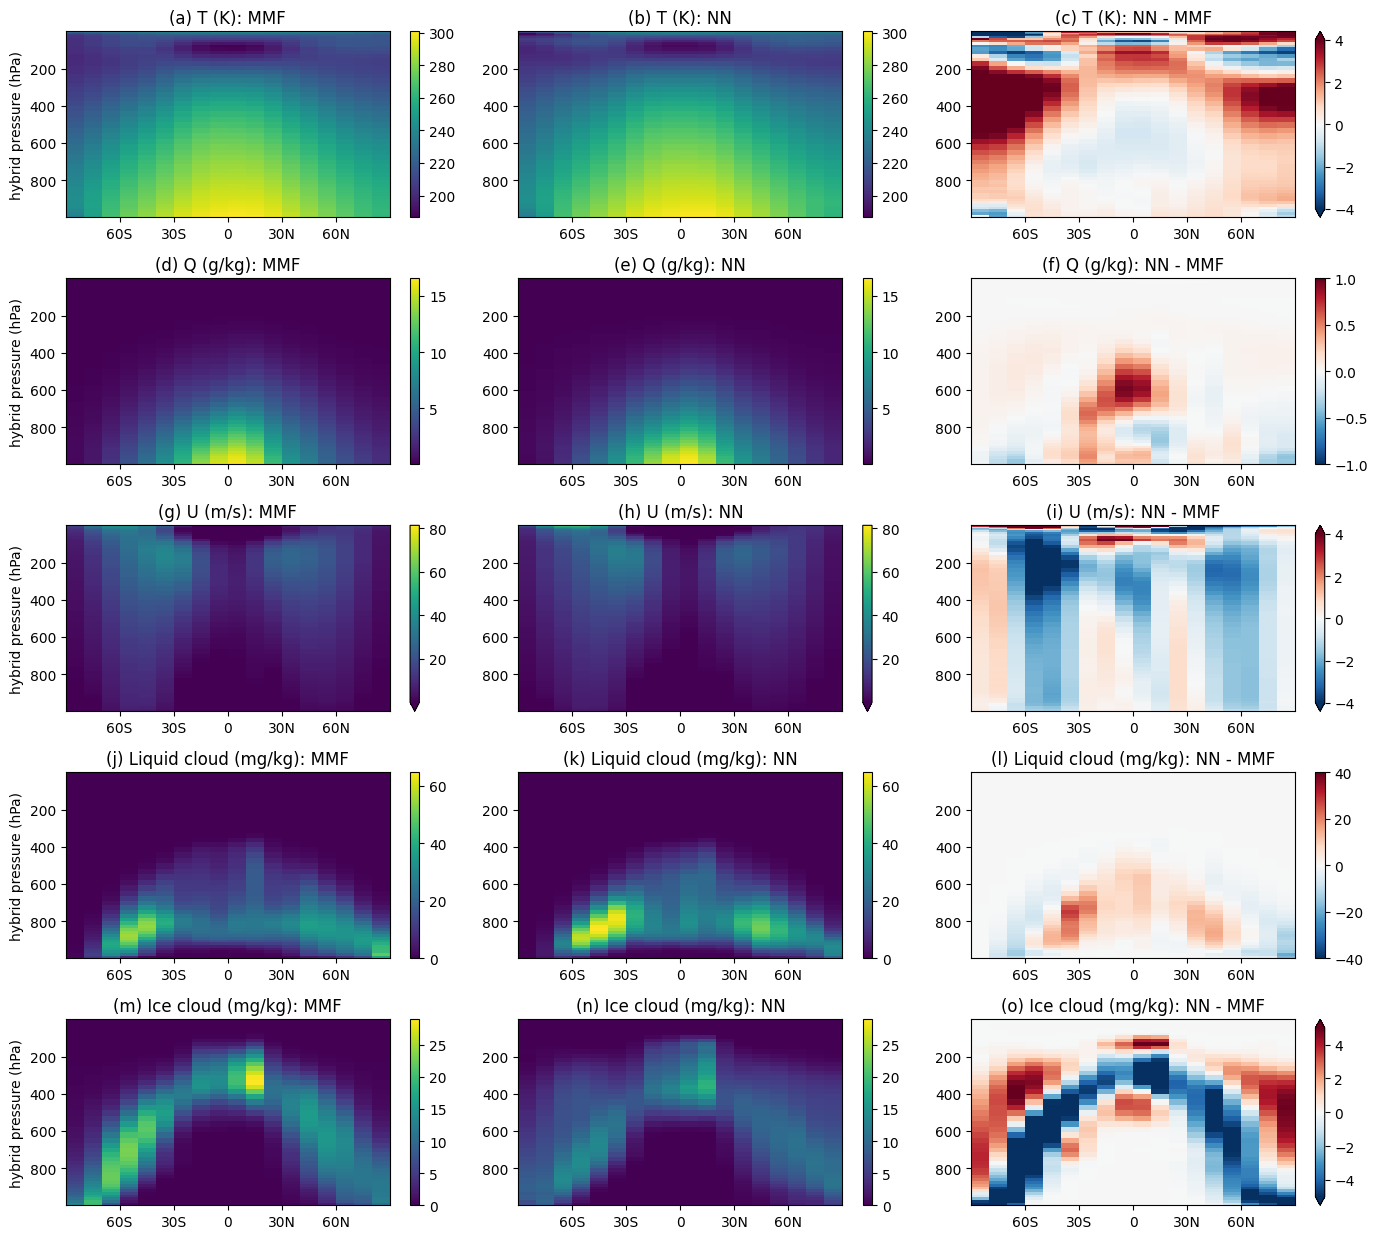

In [5]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 4},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r' , vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


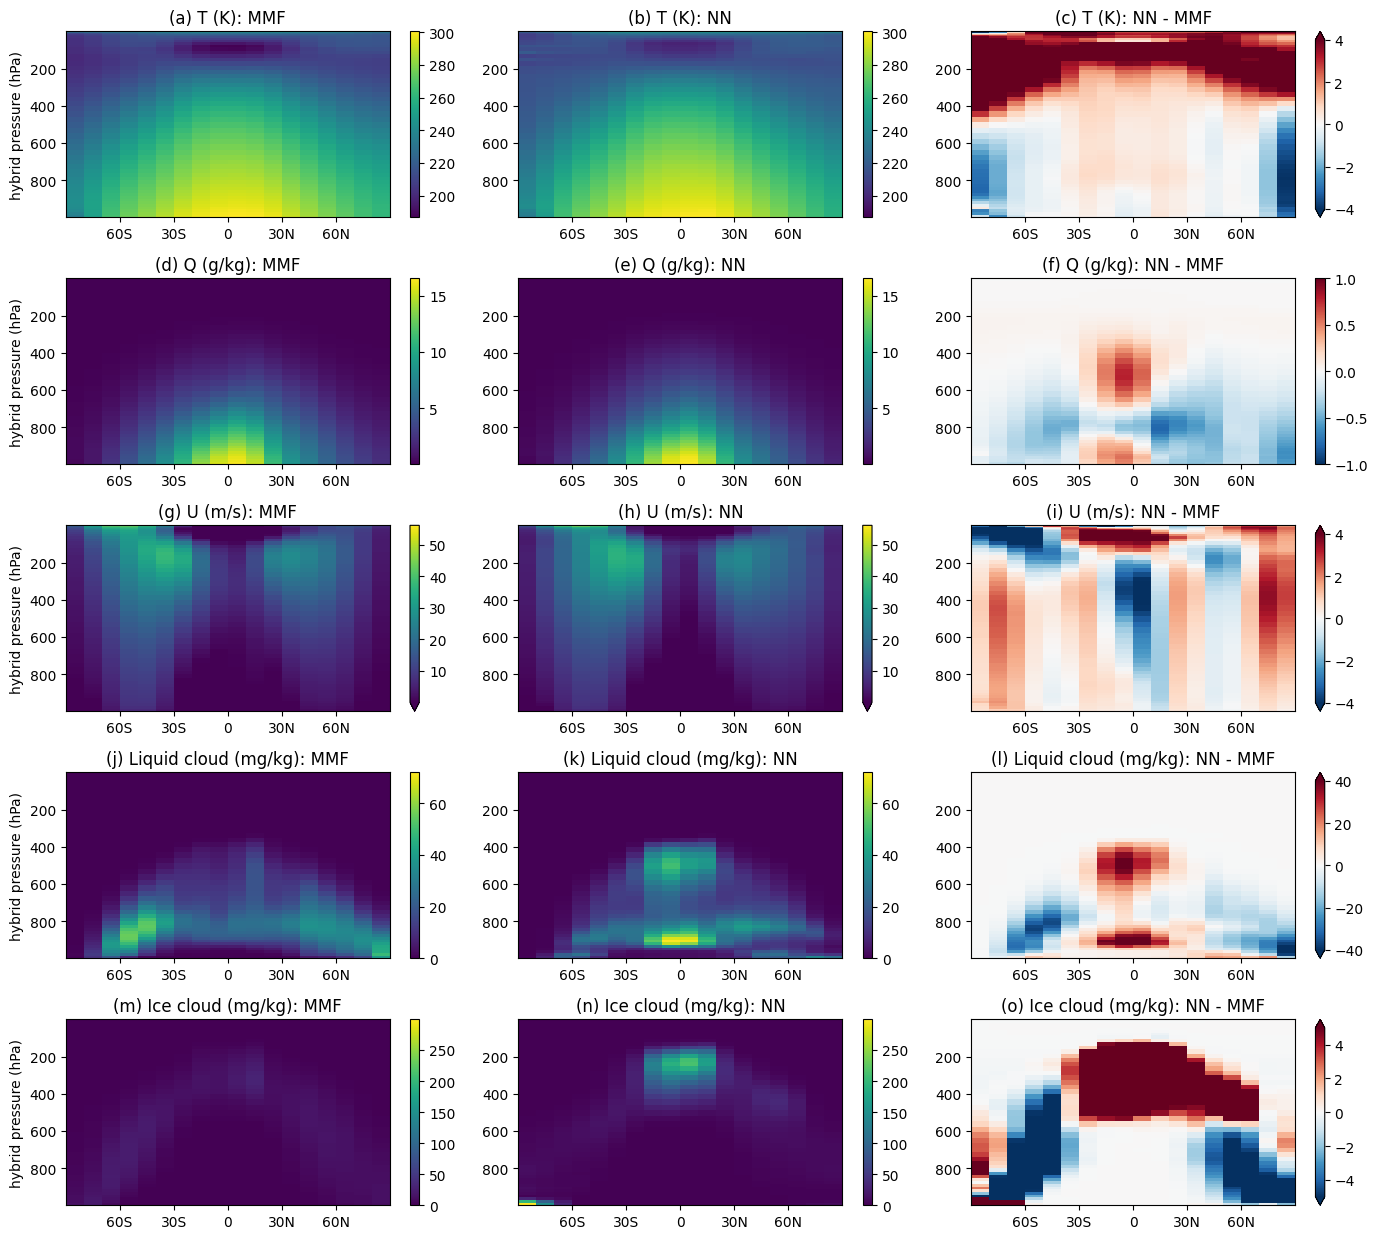

In [47]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 4},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r' , vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


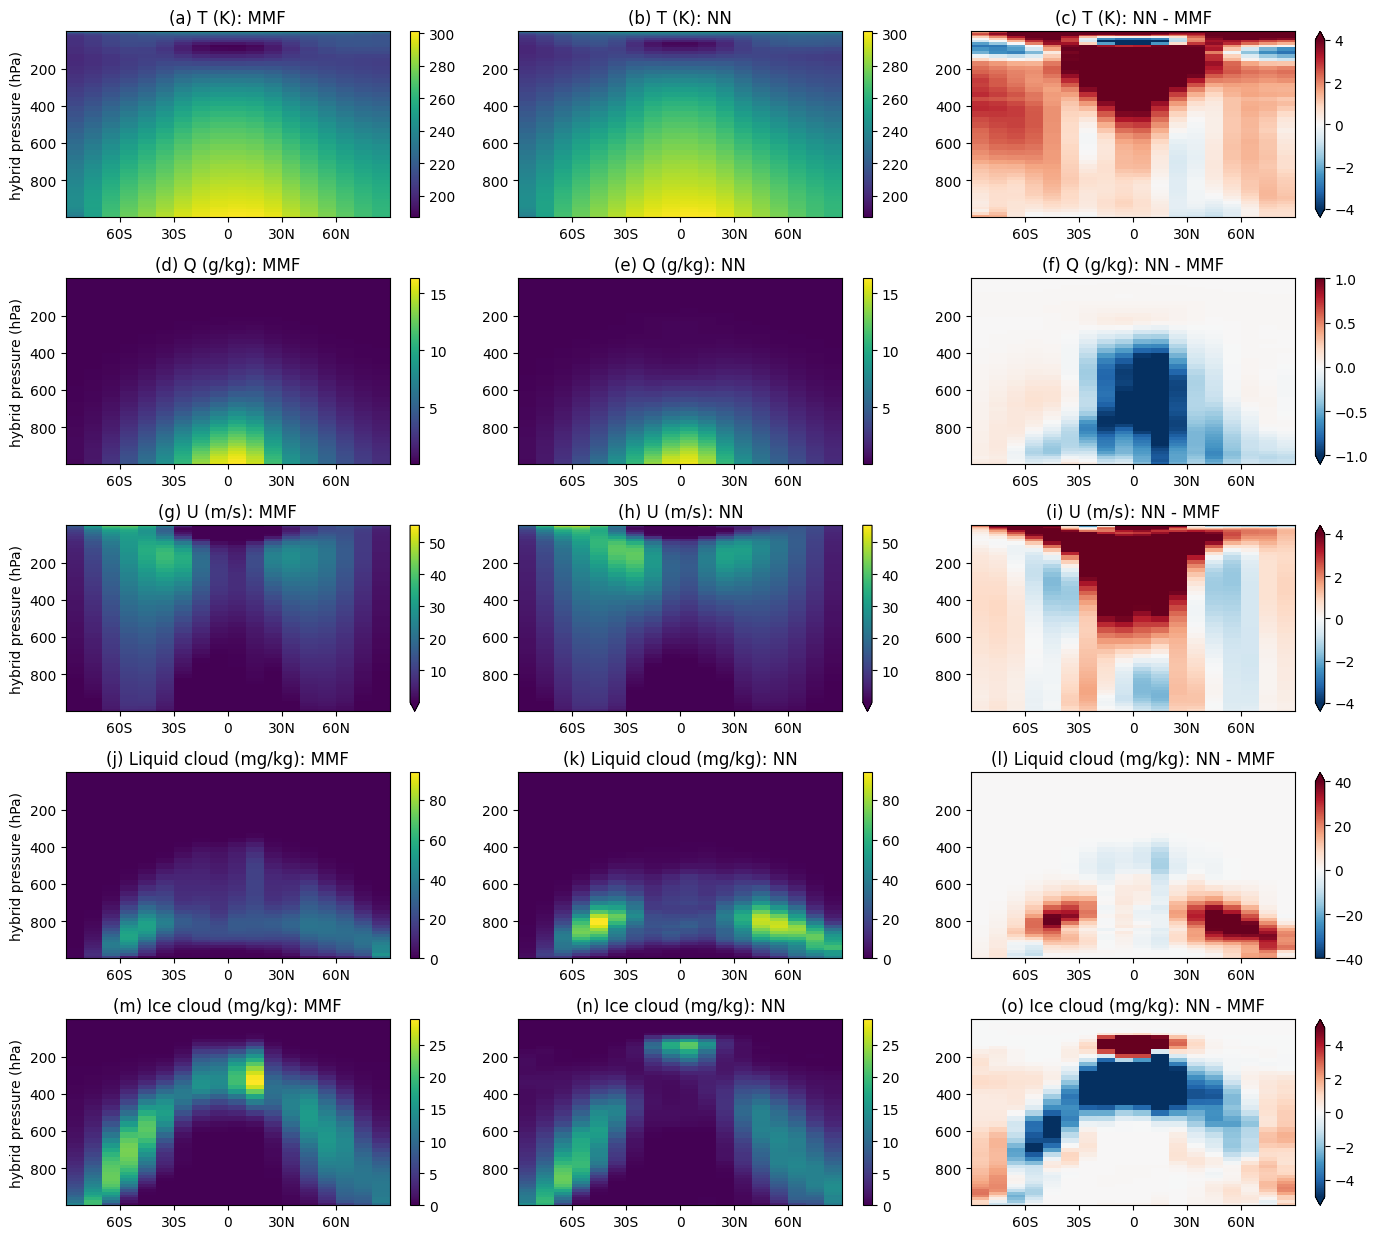

In [9]:
import matplotlib.pyplot as plt
import xarray as xr
import string


# List of variables and their settings
variables = [
    {'var': 'T', 'var_title': 'T', 'scaling': 1., 'unit': 'K', 'diff_scale': 0.9, 'max_diff': 4},
    {'var': 'Q', 'var_title': 'Q', 'scaling': 1000., 'unit': 'g/kg', 'diff_scale': 1, 'max_diff': 1},
    {'var': 'U', 'var_title': 'U', 'scaling': 1., 'unit': 'm/s', 'diff_scale': 0.2, 'max_diff': 4},
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 40},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1, 'max_diff': 5}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(5, 3, figsize=(14, 12.5)) 
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:15]]


# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp
    
    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    # if var_info['diff_scale']:
    #     vmax_diff = abs(data_diff).max() * diff_scale
    #     vmin_diff = -vmax_diff
    vmax_diff = var_info['max_diff']
    vmin_diff = -vmax_diff
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot

    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r' , vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot
    
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


In [10]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# List of variables and their settings
variables = [
    {'var': 'DTPHYS', 'var_title': 'dT/dt', 'scaling': 1., 'unit': 'K/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DQ1PHYS', 'var_title': 'dQ/dt', 'scaling': 1e3, 'unit': 'g/kg/s', 'diff_scale': 1, 'state_scale': 0.5},
    {'var': 'DUPHYS', 'var_title': 'dU/dt', 'scaling': 1., 'unit': 'm/s²', 'diff_scale': 0.25, 'state_scale': 0.16},
    {'var': 'DQnPHYS', 'var_title': 'dQn/dt', 'scaling': 1e6, 'unit': 'mg/kg/s', 'diff_scale': 0.5, 'state_scale': 0.6}
]

# Combine dQc/dt and dQi/dt into dQn/dt
ds_sp['DQnPHYS'] = ds_sp['DQ2PHYS'] + ds_sp['DQ3PHYS']
ds_nn['DQnPHYS'] = ds_nn['DQ2PHYS'] + ds_nn['DQ3PHYS']

# Create a figure with subplots (4 rows x 3 columns) to rotate the figure
fig, axs = plt.subplots(4, 3, figsize=(14, 12))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:12]]

# Loop through each variable and its corresponding subplot position
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']
    state_scale = var_info['state_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    nn_tmean = ds_nn[var].mean(dim=('time')).compute().transpose('ncol', 'lev')
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm, lats_sorted = zonal_mean_area_weighted(nn_tmean, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn = scaling * xr.DataArray(nn_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_diff = data_nn - data_sp

    # Determine color scales
    vmax = max(abs(data_sp).max(), abs(data_nn).max())
    vmin = min(abs(data_sp).min(), abs(data_nn).min())
    
    vmax = max(abs(vmax), abs(vmin)) * state_scale
    vmin = -vmax
    
    # Plot MMF for each variable in the first row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx*3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    # Plot NN for each variable in the second row
    data_nn.plot(ax=axs[idx, 1], add_colorbar=True, cmap='RdBu_r', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx*3 + 1]} {var_title} ({unit}): NN')
    axs[idx, 1].invert_yaxis()

    # Plot NN-MMF for each variable in the third row
    vmax_diff = max(abs(data_diff).max(), abs(data_diff).min()) * diff_scale
    vmin_diff = -vmax_diff
    data_diff.plot(ax=axs[idx, 2], add_colorbar=True, cmap='RdBu_r', vmin=vmin_diff, vmax=vmax_diff)
    axs[idx, 2].set_title(f'{labels[idx*3 + 2]} {var_title} ({unit}): NN - MMF')
    axs[idx, 2].invert_yaxis()

    # Clear x-labels to clean up plot
    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')
    
    if idx > 0:
        axs[idx, 0].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot
        axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

# Set these ticks and labels for each subplot
latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels

plt.tight_layout()
# plt.savefig('zonal_mean_tendency_bias_reduced_nopruning_noclass_wdiff_vertical_drop1month.pdf', format='pdf', dpi=400)
plt.show()


KeyError: "No variable named 'DQ2PHYS'. Variables on the dataset include ['area', 'hyam', 'hybm', 'P0', 'hyai', ..., 'U', 'V', 'lev', 'ilev', 'time']"

In [23]:
data_sp

<xarray.DataArray (hybrid pressure (hPa): 60, latitude: 18)> Size: 9kB
array([[3.70721706e-08, 3.70797160e-08, 3.70971491e-08, ...,
        3.84535116e-08, 3.86647459e-08, 3.88016992e-08],
       [3.73468710e-08, 3.73577177e-08, 3.73856530e-08, ...,
        3.82520312e-08, 3.85094983e-08, 3.86696570e-08],
       [3.76815346e-08, 3.77039763e-08, 3.78030149e-08, ...,
        3.81596296e-08, 3.84424594e-08, 3.86084140e-08],
       ...,
       [1.04336950e+01, 1.87317282e+01, 1.28835628e+01, ...,
        8.30566082e+00, 8.78193328e+00, 1.21389623e+01],
       [1.14939585e+01, 1.99131125e+01, 1.09433486e+01, ...,
        7.50881474e+00, 8.38614575e+00, 1.23910208e+01],
       [1.30222425e+01, 1.99112944e+01, 7.75771256e+00, ...,
        5.65184051e+00, 7.40979630e+00, 1.08921404e+01]])
Coordinates:
  * hybrid pressure (hPa)  (hybrid pressure (hPa)) float64 480B 0.07835 ... 9...
  * latitude               (latitude) int64 144B -85 -75 -65 -55 ... 55 65 75 85

## Zonal mean cloud liquid and ice zonal mean bias in unconstrained U-Net hybrid simulation exploded

Below we compare a single month's cloud liquid and ice zonal mean bias in reference MMF simulation, unconstrained U-Net, and constrained U-Net hybrid simulations. This month is where we observe that the unconstrained U-Net model experience rapid error growth.

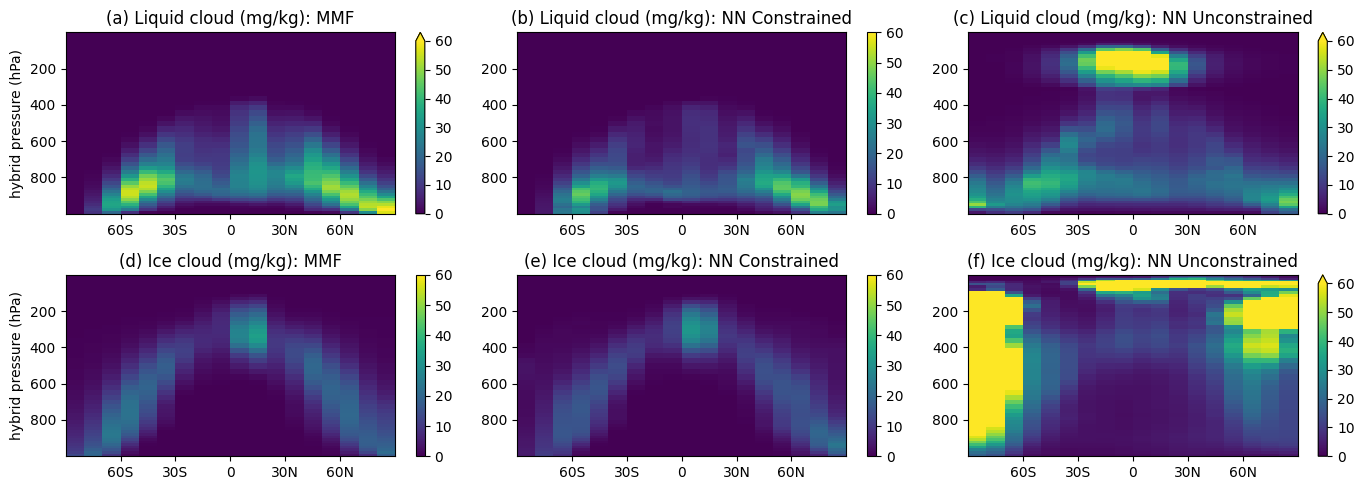

In [40]:
import matplotlib.pyplot as plt
import xarray as xr
import string

# Load the datasets
ds_sp = xr.open_dataset(data_path + 'h0/1year/mmf_ref/mmf_ref.eam.h0.0003.nc')
ds_sp['lev'].attrs['long_name'] = 'hybrid pressure'
ds_sp = ds_sp.isel(time=9)

ds_v4 = xr.open_dataset(data_path + 'h0/1year/unet_v4/huber_rop/v4_noclassifier_huber_1y_noaggressive_nomodifystqn_rop2_uoutputprune.eam.h0.0003-10.nc')
ds_v4['lev'].attrs['long_name'] = 'hybrid pressure'

ds_v5 = xr.open_dataset(data_path + 'h0/1year/unet_v5/huber_rop/v5_noclassifier_huber_1y_noaggressive_rop2.eam.h0.0003-10.nc')
ds_v5['lev'].attrs['long_name'] = 'hybrid pressure'

# List of variables and their settings for the two rows
variables = [
    {'var': 'CLDLIQ', 'var_title': 'Liquid cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1},
    {'var': 'CLDICE', 'var_title': 'Ice cloud', 'scaling': 1e6, 'unit': 'mg/kg', 'diff_scale': 1}
]

latitude_ticks = [-60, -30, 0, 30, 60]
latitude_labels = ['60S', '30S', '0', '30N', '60N']

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(14, 5))  # Adjust size as necessary
# Generate the panel labels
labels = [f"({letter})" for letter in string.ascii_lowercase[:6]]

vmaxs = [60,60]

# Loop through each variable and its corresponding subplot row
for idx, var_info in enumerate(variables):
    var = var_info['var']
    var_title = var_info['var_title']
    scaling = var_info['scaling']
    unit = var_info['unit']
    diff_scale = var_info['diff_scale']

    # Compute the means and differences for plots
    sp_tmean = ds_sp[var].compute().transpose('ncol', 'lev')
    nn_tmean_v4 = ds_v4[var][0,:,:].compute().transpose('ncol', 'lev')
    nn_tmean_v5 = ds_v5[var][0,:,:].compute().transpose('ncol', 'lev')
    
    sp_zm, lats_sorted = zonal_mean_area_weighted(sp_tmean, grid_area, lat)
    nn_zm_v4, lats_sorted = zonal_mean_area_weighted(nn_tmean_v4, grid_area, lat)
    nn_zm_v5, lats_sorted = zonal_mean_area_weighted(nn_tmean_v5, grid_area, lat)
    
    data_sp = scaling * xr.DataArray(sp_zm[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v4 = scaling * xr.DataArray(nn_zm_v4[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})
    data_nn_v5 = scaling * xr.DataArray(nn_zm_v5[:, :].T, dims=["hybrid pressure (hPa)", "latitude"],
                                     coords={"hybrid pressure (hPa)": level, "latitude": lats_sorted})

    vmax = vmaxs[idx]
    vmin=0
    
    # Plot each variable in its row
    data_sp.plot(ax=axs[idx, 0], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 0].set_title(f'{labels[idx * 3]} {var_title} ({unit}): MMF')
    axs[idx, 0].invert_yaxis()

    data_nn_v4.plot(ax=axs[idx, 2], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 2].set_title(f'{labels[idx * 3 + 2]} {var_title} ({unit}): NN Unconstrained')
    axs[idx, 2].invert_yaxis()
    axs[idx, 2].set_ylabel('')  # Clear the y-label to clean up plot

    
    data_nn_v5.plot(ax=axs[idx, 1], add_colorbar=True, cmap='viridis', vmin=vmin, vmax=vmax)
    axs[idx, 1].set_title(f'{labels[idx * 3 + 1]} {var_title} ({unit}): NN Constrained')
    axs[idx, 1].invert_yaxis()
    axs[idx, 1].set_ylabel('')  # Clear the y-label to clean up plot


    axs[idx, 0].set_xlabel('')
    axs[idx, 1].set_xlabel('')
    axs[idx, 2].set_xlabel('')

# Set these ticks and labels for each subplot
for ax_row in axs:
    for ax in ax_row:
        ax.set_xticks(latitude_ticks)  # Set the positions for the ticks
        ax.set_xticklabels(latitude_labels)  # Set the custom text labels
plt.tight_layout()
plt.show()


In [14]:
ds_sp

<xarray.Dataset> Size: 561kB
Dimensions:    (ncol: 384, lev: 60, ilev: 61, nbnd: 2)
Coordinates:
  * lev        (lev) float64 480B 0.07835 0.1411 0.2529 ... 963.6 978.0 992.6
  * ilev       (ilev) float64 488B 0.05588 0.1008 0.1814 ... 970.8 985.3 1e+03
    time       object 8B 0003-11-01 00:00:00
Dimensions without coordinates: ncol, nbnd
Data variables: (12/14)
    area       (ncol) float64 3kB ...
    hyam       (lev) float64 480B ...
    hybm       (lev) float64 480B ...
    P0         float64 8B ...
    hyai       (ilev) float64 488B ...
    hybi       (ilev) float64 488B ...
    ...         ...
    CLDLIQ     (lev, ncol) float32 92kB ...
    PS         (ncol) float32 2kB ...
    Q          (lev, ncol) float32 92kB ...
    T          (lev, ncol) float32 92kB ...
    U          (lev, ncol) float32 92kB ...
    V          (lev, ncol) float32 92kB ...
Attributes: (12/20)
    ne:                4
    fv_nphys:          2
    title:             EAM History file information
    source:            E3SM Atmosphere Model
    source_id:         c06d2e537a
    product:           model-output
    ...                ...
    institution:       LLNL (Lawrence Livermore National Laboratory, Livermor...
    contact:           e3sm-data-support@llnl.gov
    initial_file:      /global/cfs/cdirs/e3sm/inputdata/atm/cam/inic/homme/ea...
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    time_period_freq:  month_1
    NCO:               netCDF Operators version 5.1.6 (Homepage = http://nco....

In [15]:
sp_zm

array([[2.28754491e-14, 2.27974039e-14, 2.28281457e-14, ...,
        1.00722690e-05, 1.09309942e-05, 1.31495816e-05],
       [2.28340836e-14, 2.27339016e-14, 2.26960452e-14, ...,
        1.77528437e-05, 1.93553522e-05, 1.95198618e-05],
       [2.27411369e-14, 2.26671490e-14, 2.26542041e-14, ...,
        1.58061298e-05, 1.35118230e-05, 9.55897374e-06],
       ...,
       [2.37968256e-14, 2.38774467e-14, 2.37213839e-14, ...,
        6.26498109e-06, 4.52267476e-06, 2.74357257e-06],
       [2.40668151e-14, 2.42905286e-14, 2.45023391e-14, ...,
        1.50217481e-05, 1.23544482e-05, 8.04769478e-06],
       [2.43513782e-14, 2.46973407e-14, 2.54057313e-14, ...,
        1.94875799e-05, 2.10237024e-05, 1.80342494e-05]])